In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import os

import torch
from torch import nn, optim
from torchvision import transforms
import torchvision.transforms as tt


import segmentation_models_pytorch as smp

from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.DataFrame()

In [4]:
for n in os.listdir('lesson_10/'):
    if n == '.DS_Store':
        break
    for sign in os.listdir('lesson_10/'+n+'/'):
        if sign == '.DS_Store':
            break
        for location in os.listdir('lesson_10/'+n+'/'+sign+'/'):
            df = df.append({'Location': 'lesson_10/'+n+'/'+sign+'/'+location, 'Sign':sign},ignore_index=True)

In [5]:
df

,Location,Sign
0,lesson_10/03/05_thumb/frame_03_05_0165.png,05_thumb
1,lesson_10/03/05_thumb/frame_03_05_0171.png,05_thumb
2,lesson_10/03/05_thumb/frame_03_05_0159.png,05_thumb
3,lesson_10/03/05_thumb/frame_03_05_0011.png,05_thumb
4,lesson_10/03/05_thumb/frame_03_05_0005.png,05_thumb
...,...,...
795,lesson_10/02/05_thumb/frame_02_05_0112.png,05_thumb
796,lesson_10/02/05_thumb/frame_02_05_0106.png,05_thumb
797,lesson_10/02/05_thumb/frame_02_05_0099.png,05_thumb
798,lesson_10/02/05_thumb/frame_02_05_0066.png,05_thumb


In [6]:
train_dataset, valid_dataset = train_test_split(df, test_size=0.25, random_state=13)

In [7]:
location = train_dataset['Location'][1]
sign = train_dataset['Sign'][1]

In [8]:
img = cv2.imread(location)

05_thumb


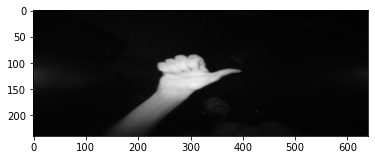

In [9]:
plt.imshow(img)
print(sign)

In [10]:
img = cv2.resize(img, (256, 256))
img = np.asarray(img).astype('float')
img = torch.as_tensor(img) / 255.0
img = img.permute(2, 0, 1)

torch.Size([3, 256, 256])


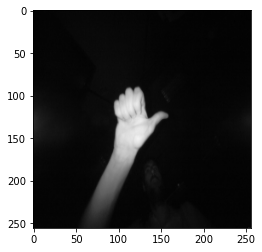

In [11]:
print(img.shape)
fig, ax = plt.subplots()
ax.imshow(img.permute(1, 2, 0))
plt.show()

In [12]:
def to_class(sign):
    if sign == '01_palm':
        return 0
    elif sign == '02_l':
        return 1
    elif sign == '03_fist':
        return 2
    elif sign == '04_fist_moved':
        return 3
    elif sign == '05_thumb':
        return 4
    elif sign == '06_index':
        return 5
    elif sign == '07_ok':
        return 6
    elif sign == '08_palm_moved':
        return 7
    elif sign == '09_c':
        return 8
    elif sign == '10_down':
        return 9

In [13]:
train_tfms = tt.Compose([
                         tt.ToPILImage(),
                         tt.Grayscale(num_output_channels=1),
                         tt.Resize((256,256)),
                         tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(30), 
                         tt.ToTensor()])

test_tfms =  tt.Compose([
                         tt.ToPILImage(),
                         tt.Grayscale(num_output_channels=1),
                         tt.Resize((256,256)),
                         tt.ToTensor()])

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.data_location = data['Location']
        self.data_sign = data['Sign']
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, idx):
        img = cv2.imread(self.data_location[idx])
        if self.transform is not None: 
            img = self.transform(img)

        sign = self.data_sign[idx]
        sign_class = to_class(sign)

        return (img, sign_class)

In [15]:
train_dataset.reset_index(drop=True,inplace=True)
valid_dataset.reset_index(drop=True,inplace=True)

In [16]:
train_dataset = MyDataset(train_dataset, transform=train_tfms)
valid_dataset = MyDataset(valid_dataset, transform=test_tfms)

torch.Size([1, 256, 256])
4


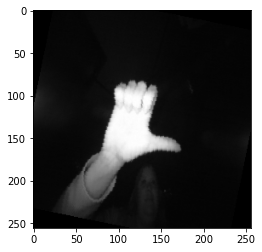

In [17]:
img, sign = train_dataset[2]
print(img.shape)
print(sign)
plt.imshow(img.permute(1, 2, 0)[:,:,0], cmap='gray')
plt.show()

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                              batch_size=256,
                              shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                              batch_size=256,
                              shuffle=False)

torch.Size([256, 1, 256, 256])
tensor(0.) tensor(0.9922)
tensor(4)


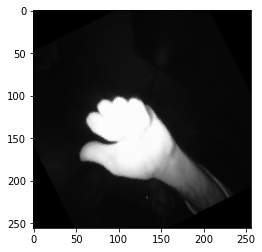

In [19]:
for img, sign in train_loader:
    print(img.shape)
    print(img[0].min(), img[0].max())
    print(sign[0])
    fig, ax = plt.subplots()
    ax.imshow(img[0].permute(1, 2, 0), cmap='gray')
    break

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [21]:
class Net(nn.Module):
    
    def dense_block(self, input_features, out_features, dropout):
        return nn.Sequential(
            nn.Linear(input_features, out_features), 
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def __init__(self):
        super().__init__()
        
        self.conv_one = torch.nn.Conv2d(1, 64, kernel_size=3)
        self.mp_one = torch.nn.MaxPool2d((2,2)) 
        
        self.conv_two = torch.nn.Conv2d(64, 128, kernel_size=3)
        self.mp_two = torch.nn.MaxPool2d((2,2), stride=(2,2)) 
        
        self.conv_three = torch.nn.Conv2d(128, 256, kernel_size=3)
        self.mp_three = torch.nn.MaxPool2d((2,2), stride=(2,2)) 
        
        self.conv_four = torch.nn.Conv2d(256, 512, kernel_size=3)
        self.mp_four = torch.nn.MaxPool2d((2,2), stride=(2,2))
        
        #self.conv_five = torch.nn.Conv2d(512, 512, kernel_size=3)
        #self.mp_five = torch.nn.MaxPool2d((2,2), stride=(2,2))
        
        self.fl = nn.Flatten()
        
        self.classifier = nn.Sequential(
            self.dense_block(100352, 256, 0.2),
            self.dense_block(256, 128, 0.2),
            nn.Linear(128, 10), 
            nn.ReLU())
        
    def forward(self, x):
        x = self.conv_one(x)
        x = self.mp_one(x)
        x = self.conv_two(x)
        x = self.mp_two(x)
        x = self.conv_three(x)
        x = self.mp_three(x)
        x = self.conv_four(x)
        x = self.mp_four(x)
        x = self.fl(x)
        x = self.classifier(x)
        
        return x

In [22]:
net = Net()

net.to(device)

net.train()

Net(
  (conv_one): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp_one): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_two): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (mp_two): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_three): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (mp_three): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_four): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (mp_four): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100352, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      

In [23]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
from torch.nn import functional as F

In [25]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        print(inputs.shape)
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/3]. Loss: 0.009. Acc: 0.188. Test acc: 1.000
Epoch [2/10]. Step [1/3]. Loss: 0.007. Acc: 0.625. Test acc: 0.845
Epoch [3/10]. Step [1/3]. Loss: 0.006. Acc: 0.703. Test acc: 0.800
Epoch [4/10]. Step [1/3]. Loss: 0.005. Acc: 0.734. Test acc: 0.760
Epoch [5/10]. Step [1/3]. Loss: 0.004. Acc: 0.770. Test acc: 0.800
Epoch [6/10]. Step [1/3]. Loss: 0.004. Acc: 0.770. Test acc: 0.845
Epoch [7/10]. Step [1/3]. Loss: 0.004. Acc: 0.809. Test acc: 0.845
Epoch [8/10]. Step [1/3]. Loss: 0.004. Acc: 0.770. Test acc: 0.845
Epoch [9/10]. Step [1/3]. Loss: 0.003. Acc: 0.809. Test acc: 0.845
Epoch [10/10]. Step [1/3]. Loss: 0.003. Acc: 0.816. Test acc: 0.845
Training is finished!


In [26]:
def digit_to_classname(digit):
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

torch.Size([200, 1, 256, 256])


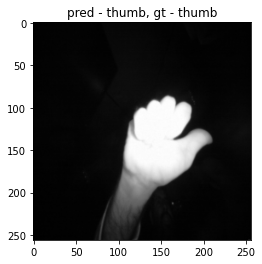

In [27]:
with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        print(images.shape)
        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].squeeze().cpu(), cmap='gray')
        plt.show()
        if i>6:
            break